# Loading the libraries

In [2]:
!pip install transformers

     |████████████████████████████████| 757kB 12.9MB/s 
     |████████████████████████████████| 1.1MB 56.9MB/s 
     |████████████████████████████████| 3.0MB 53.2MB/s 
     |████████████████████████████████| 890kB 51.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=e3a5c98fb7b1318b46b32d87b69d721308953dd5366dbfa4c7fc59440202ab18
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
import pandas as pd
import uuid
import os
import random
from argparse import Namespace

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.utils.data.distributed import DistributedSampler

from tqdm import tqdm, trange

from transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer)
from transformers import AdamW, get_linear_schedule_with_warmup

MODEL_CLASSES = { 'bert': (BertConfig, BertForSequenceClassification, BertTokenizer) }

import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level= logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
# loading drive to access the data
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data Playground

## Slice the data into two

In [ ]:
import numpy as np
import pandas as pd

data = pd.read_csv('/content/drive/My Drive/Team 4/WorkOnMergedData/final_merged_data.csv')
data['Leading Comment'] = data['Leading Comment'].apply(lambda x: str(x))
data['Category'] = data['Category'].apply(lambda x: str(x))
data['Reply Comments'] = data['Reply Comments'].apply(lambda x: str(x))
df = data[['Leading Comment', 'Reply Comments', 'Category']] 
df.head()

,Leading Comment,Reply Comments,Category
0,Yesterday I lowered the price of an item to ma...,['Isn’t that what you were trying to do??? Mat...,Fulfillment By Amazon
1,I got my new credit card and before I could up...,"['You can’t. You just have to wait.', 'You can...",Fulfillment By Amazon
2,I sent an FBA shipment on November 26. They sh...,['This topic was automatically closed 180 days...,Fulfillment By Amazon
3,"Hi, I need to know the products stock in Selle...",['You need to have a professional account and ...,Fulfillment By Amazon
4,Just here to vent at the Asia based Seller Sup...,['Illuminations_Brand\nIf you’re here in the U...,Fulfillment By Amazon


In [ ]:
import re
from bs4 import BeautifulSoup

REPLACE_BY_SPACE_RE = re.compile('[(){}\[\]|@]')
#BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
SET_OF_NUMBERS_RE = re.compile('[0-9]{4,}')
#STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = SET_OF_NUMBERS_RE.sub('', text) # remove things like : n73457690485992199537918jpeg8281792 
    text = text.replace(r'jpeg', '')
    #text = ''.join(word for word in text if word not in punct)  # remove punctuation
    #text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text
    
df['Reply Comments'] = df['Reply Comments'].apply(clean_text)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df['Reply Comments'][0]

" 'Isn’t that what you were trying to do??? Matching the Buy Box helps increase sales…\\nOr are you saying you’ve somehow sold more inventory than you have?', 'Always been just one item', 'So you only had a quantity of 1 in FBA? And 5 sold?\\nCan you share a screenshot of what you’re seeing?', '6E14CA6F--426F-A7E1-35CA7A36.828× 204 KB\\n \\nECB-69F0-485A--9DDCB8.828× 206 KB\\n \\n4E23C9E9-C057-494C-8F6C-90ABAABB15EE.828× 215 KB\\n \\n4EAED4B8--4E78-86FA-A49F87DB283A.828× 225 KB', 'Pics are out of order but five total', 'That’s how many they ordered, not how many you have in stock.', 'Correct. I only had a quantity of one in fba and five sold', 'Maybe I’m saying it wrong. I listed one , created a shipping order for one and only mailed one to amazon  fba  That’s all I’ve had was one. So I can’t figure out how five different people are in the “process” of buying it.', 'Do you have a different quantity FBM inventory?', 'I’ve had this happen before. It’s like amazon shoots its load early in

In [ ]:
reply_comments_df = pd.DataFrame({'texts': df['Reply Comments'],
                                  'labels': df['Category']})

In [ ]:
reply_comments_df.head()

,texts,labels
0,'Isn’t that what you were trying to do??? Mat...,Fulfillment By Amazon
1,"'You can’t. You just have to wait.', 'You can...",Fulfillment By Amazon
2,'This topic was automatically closed 180 days...,Fulfillment By Amazon
3,'You need to have a professional account and ...,Fulfillment By Amazon
4,'Illuminations_Brand\nIf you’re here in the U...,Fulfillment By Amazon


In [ ]:
reply_comments_df.isna().sum()

texts     0
labels    0
dtype: int64

In [ ]:
df.rename(columns={'Leading Comment': 'texts', 'Category': 'labels'}, inplace=True)
df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,texts,Reply Comments,labels
0,Yesterday I lowered the price of an item to ma...,'Isn’t that what you were trying to do??? Mat...,Fulfillment By Amazon
1,I got my new credit card and before I could up...,"'You can’t. You just have to wait.', 'You can...",Fulfillment By Amazon
2,I sent an FBA shipment on November 26. They sh...,'This topic was automatically closed 180 days...,Fulfillment By Amazon
3,"Hi, I need to know the products stock in Selle...",'You need to have a professional account and ...,Fulfillment By Amazon
4,Just here to vent at the Asia based Seller Sup...,'Illuminations_Brand\nIf you’re here in the U...,Fulfillment By Amazon


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8841 entries, 0 to 8840
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   texts           8841 non-null   object
 1   Reply Comments  8841 non-null   object
 2   labels          8841 non-null   object
dtypes: object(3)
memory usage: 207.3+ KB


In [ ]:
df.columns

Index(['texts', 'Reply Comments', 'labels'], dtype='object')

In [ ]:
df.drop(columns=['Reply Comments'], inplace=True)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

df.head()

,texts,labels
0,Yesterday I lowered the price of an item to ma...,Fulfillment By Amazon
1,I got my new credit card and before I could up...,Fulfillment By Amazon
2,I sent an FBA shipment on November 26. They sh...,Fulfillment By Amazon
3,"Hi, I need to know the products stock in Selle...",Fulfillment By Amazon
4,Just here to vent at the Asia based Seller Sup...,Fulfillment By Amazon


In [ ]:
new_df = pd.concat([df, reply_comments_df], ignore_index=True)

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17682 entries, 0 to 17681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   17682 non-null  object
 1   labels  17682 non-null  object
dtypes: object(2)
memory usage: 276.4+ KB


In [ ]:
new_df['texts'][8838]

'Have questions about sourcing the various sales channels available to you? This is the category to use. Please be sure to select the most appropriate sub-category for your questions.'

In [ ]:
new_df.isna().sum()

texts     0
labels    0
dtype: int64

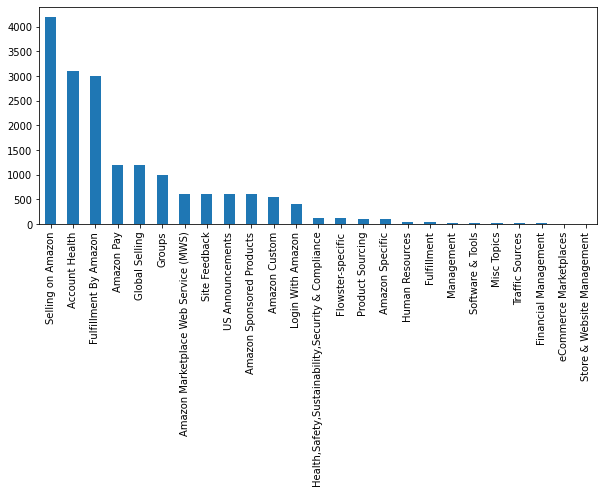

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,4))
new_df.labels.value_counts().plot(kind='bar');

In [ ]:
new_df.labels.unique()

array(['Fulfillment By Amazon', 'Amazon Sponsored Products',
       'Account Health', 'Selling on Amazon', 'Global Selling', 'Groups',
       'Health,Safety,Sustainability,Security & Compliance',
       'Amazon Marketplace Web Service (MWS)', 'Login With Amazon',
       'Amazon Pay', 'Amazon Custom', 'US Announcements', 'Site Feedback',
       'Financial Management', 'Product Sourcing', 'Human Resources',
       'Amazon Specific', 'Flowster-specific', 'Software & Tools',
       'Fulfillment', 'Traffic Sources', 'Management', 'Misc Topics',
       'eCommerce Marketplaces', 'Store & Website Management'],
      dtype=object)

In [ ]:
new_df.labels.unique().shape

(25,)

In [ ]:
categories = ['Fulfillment By Amazon', 'Amazon Sponsored Products',
       'Account Health', 'Selling on Amazon', 'Global Selling', 'Groups',
       'Health,Safety,Sustainability,Security & Compliance',
       'Amazon Marketplace Web Service (MWS)', 'Login With Amazon',
       'Amazon Pay', 'Amazon Custom', 'US Announcements', 'Site Feedback',
       'Financial Management', 'Product Sourcing', 'Human Resources',
       'Amazon Specific', 'Flowster-specific', 'Software & Tools',
       'Fulfillment', 'Traffic Sources', 'Management', 'Misc Topics',
       'eCommerce Marketplaces', 'Store & Website Management']

In [ ]:
# categories with less data
categ_wld = ['Health,Safety,Sustainability,Security & Compliance',
       'Financial Management', 'Product Sourcing', 'Human Resources',
       'Amazon Specific', 'Flowster-specific', 'Software & Tools',
       'Fulfillment', 'Traffic Sources', 'Management', 'Misc Topics',
       'eCommerce Marketplaces', 'Store & Website Management']
len(categ_wld)

13

In [ ]:
# dataframe with only the categories containing less data
data_wlc = new_df[new_df['labels'].isin(categ_wld)]

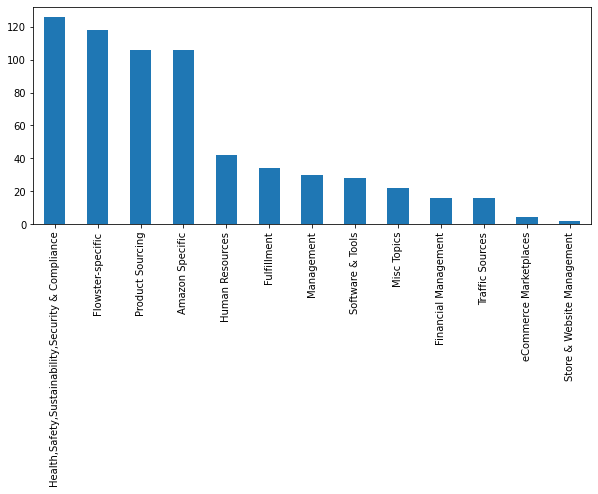

In [ ]:
plt.figure(figsize=(10,4))
data_wlc.labels.value_counts().plot(kind='bar');

In [ ]:
categ_wed = []
for categ in categories:
  if categ not in categ_wld:
    # category with enough data
    categ_wed.append(categ)

In [ ]:
len(categ_wed)

12

In [ ]:
# dataframe with only the categories containing enough data
data_wec = new_df[new_df['labels'].isin(categ_wed)]

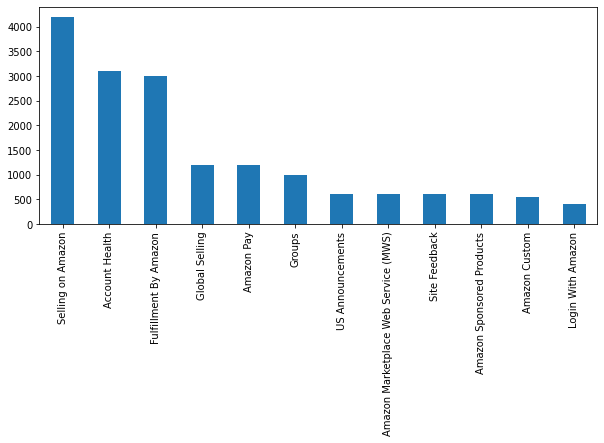

In [ ]:
plt.figure(figsize=(10,4))
data_wec.labels.value_counts().plot(kind='bar');

In [ ]:
data_wec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17032 entries, 0 to 17419
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   17032 non-null  object
 1   labels  17032 non-null  object
dtypes: object(2)
memory usage: 399.2+ KB


## Augment the data

In [ ]:
!pip install git+https://github.com/makcedward/nlpaug.git numpy matplotlib python-dotenv

  Cloning https://github.com/makcedward/nlpaug.git to /tmp/pip-req-build-o1ji6ind
  Running command git clone -q https://github.com/makcedward/nlpaug.git /tmp/pip-req-build-o1ji6ind
  Created wheel for nlpaug: filename=nlpaug-0.0.14-cp36-none-any.whl size=583433 sha256=9eb35358daec8e73d51a9b409f7d0720a851e3d874aa5e28b83c07557e6361b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-xu186be6/wheels/2b/ef/30/a4e22f9a97373c9ab6763670c94aa5e111b0b956983f3892a4
Successfully built nlpaug


In [ ]:
cd /content/drive/My Drive/Team 4/WorkOnMergedData

/content/drive/.shortcut-targets-by-id/1PXqnOQuOVInoF3I67K_93-Qpq7PKhVCX/WorkOnMergedData


In [ ]:
!git clone https://github.com/makcedward/nlpaug.git

fatal: destination path 'nlpaug' already exists and is not an empty directory.


In [ ]:
cd nlpaug

/content/drive/.shortcut-targets-by-id/1PXqnOQuOVInoF3I67K_93-Qpq7PKhVCX/WorkOnMergedData/nlpaug


In [ ]:
import os
os.environ["MODEL_DIR"] = '../model'

In [ ]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

In [ ]:
# augmenting with BERT
texts = data_wlc['texts']
augmented_text_bert = []
aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="substitute")
for text in texts:
  augmented_text_bert.append(aug.augment(text))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# augmenting with DistillBERT
texts = data_wlc['texts']
augmented_text_distilbert = []
aug = naw.ContextualWordEmbsAug(
    model_path='distilbert-base-uncased', action="substitute")
for text in texts:
  augmented_text_distilbert.append(aug.augment(text))

In [ ]:
# bert-base-uncased
print("Original:")
print(texts[0:1].values)
print("Augmented Text:")
print(augmented_text_bert[0])

Original:
['Amazon is asking me to provide them with a registration of my product. I did submit them a registration but they said it’s not the correct one. I buy the ingredient of the capsules from a manuafacturer, then I repackaged them and sell. I have know clue on how to register on the FDA website because they only allowed me to register a food facility. Please help me!!!']
Augmented Text:
amazon is asking me to grant them with automatic registration of my product . i did give them a registration but they said it ’ was not the correct one . they buy the ingredient of its capsules from a manuafacturer , then quickly repackaged them and sell . i only know clue on how to register on an fda website because they only allowed me use register a food facility . please help me ! ! !


In [ ]:
# distillbert-base-uncased
print("Original:")
print(texts[0:1].values)
print("Augmented Text:")
print(augmented_text_distilbert[0])

Original:
['Amazon is asking me to provide them with a registration of my product. I did submit them a registration but they said it’s not the correct one. I buy the ingredient of the capsules from a manuafacturer, then I repackaged them and sell. I have know clue on how to register on the FDA website because they only allowed me to register a food facility. Please help me!!!']
Augmented Text:
amazon is asking me to provide them with a capsule of my product . i technically give them a registration but they said it ’ s essentially a correct one . i extracted an ingredient of the capsules from a manuafacturer , then i repackaged them and sell . i have know clue exactly how to read on an fda website because they only allowed me to register a food facility . please help me ! ! !


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
# Substitute word by WordNet's synonym
augmented_text_wordnet = []
aug = naw.SynonymAug(aug_src='wordnet')
for text in texts:
  augmented_text_wordnet.append(aug.augment(text))

print("Original:")
print(texts[0:1].values)
print("Augmented Text:")
print(augmented_text_wordnet[0])

Original:
['Amazon is asking me to provide them with a registration of my product. I did submit them a registration but they said it’s not the correct one. I buy the ingredient of the capsules from a manuafacturer, then I repackaged them and sell. I have know clue on how to register on the FDA website because they only allowed me to register a food facility. Please help me!!!']
Augmented Text:
Amazon is asking me to provide them with a registration of my product . I did relegate them a enrollment but they said it ’ s not the correct one . I corrupt the ingredient of the capsules from a manuafacturer , and then 1 repackaged them and sell . I sustain jazz clue on how to register on the FDA website because they only allowed me to register a food facility . Please help me ! ! !


In [ ]:
# augmenting with bert
aug_data = pd.DataFrame({'texts':augmented_text_bert,
                         'labels': data_wlc['labels']})
aug_data.head()

,texts,labels
4202,amazon is asking me to grant them with automat...,"Health,Safety,Sustainability,Security & Compli..."
4203,"if infringement is complained , i presented th...","Health,Safety,Sustainability,Security & Compli..."
4204,hi … amazon classified about 100 of my listing...,"Health,Safety,Sustainability,Security & Compli..."
4205,"hello there , amazon suspended my account beca...","Health,Safety,Sustainability,Security & Compli..."
4206,"hello , you asked me why i installed suspected...","Health,Safety,Sustainability,Security & Compli..."


In [ ]:
# augmenting with distillbert
aug_data = pd.concat([aug_data, pd.DataFrame({'texts':augmented_text_distilbert,
                         'labels': data_wlc['labels']})], ignore_index=True)
aug_data.head()

,texts,labels
0,amazon is asking me to grant them with automat...,"Health,Safety,Sustainability,Security & Compli..."
1,"if infringement is complained , i presented th...","Health,Safety,Sustainability,Security & Compli..."
2,hi … amazon classified about 100 of my listing...,"Health,Safety,Sustainability,Security & Compli..."
3,"hello there , amazon suspended my account beca...","Health,Safety,Sustainability,Security & Compli..."
4,"hello , you asked me why i installed suspected...","Health,Safety,Sustainability,Security & Compli..."


In [ ]:
aug_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   1300 non-null   object
 1   labels  1300 non-null   object
dtypes: object(2)
memory usage: 20.4+ KB


In [ ]:
# augmenting with wordnet
aug_data = pd.concat([aug_data, pd.DataFrame({'texts':augmented_text_wordnet,
                         'labels': data_wlc['labels']})], ignore_index=True)

In [ ]:
aug_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950 entries, 0 to 1949
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   1950 non-null   object
 1   labels  1950 non-null   object
dtypes: object(2)
memory usage: 30.6+ KB


In [ ]:
aug_data_wlc = data_wlc.copy()

In [ ]:
aug_data_wlc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2600 entries, 4202 to 1949
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   2600 non-null   object
 1   labels  2600 non-null   object
dtypes: object(2)
memory usage: 60.9+ KB


In [ ]:
aug_data_wlc = pd.concat([aug_data_wlc, aug_data], ignore_index=True)

In [ ]:
aug_data_wlc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   6500 non-null   object
 1   labels  6500 non-null   object
dtypes: object(2)
memory usage: 101.7+ KB


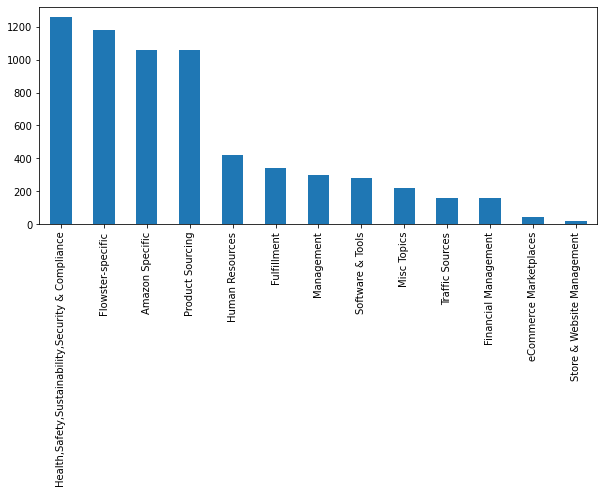

In [ ]:
plt.figure(figsize=(10,4))
aug_data_wlc.labels.value_counts().plot(kind='bar');

In [ ]:
full_aug_data = data_wec.append(aug_data_wlc)

In [ ]:
full_aug_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23532 entries, 0 to 6499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   23532 non-null  object
 1   labels  23532 non-null  object
dtypes: object(2)
memory usage: 551.5+ KB


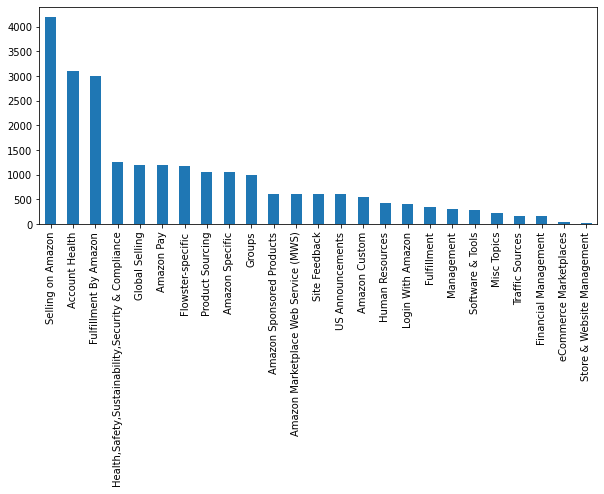

In [ ]:
plt.figure(figsize=(10,4))
full_aug_data.labels.value_counts().plot(kind='bar');

In [ ]:
cd /content/drive/.shortcut-targets-by-id/1PXqnOQuOVInoF3I67K_93-Qpq7PKhVCX/WorkOnMergedData

/content/drive/.shortcut-targets-by-id/1PXqnOQuOVInoF3I67K_93-Qpq7PKhVCX/WorkOnMergedData


In [ ]:
full_aug_data['texts'] = full_aug_data['texts'].apply(lambda x: str(x))
full_aug_data['labels'] = full_aug_data['labels'] .apply(lambda x: str(x))

In [ ]:
full_aug_data.to_csv('full_aug_data_v2.csv')

# Playing around with the data (slicing - augmenting)
**STEP 1: Slicing the data**  
We will work with the dataframe which categories has data with a minimum of 250 examples.  
**Goal:** Determine if the number of examples in a category affects the performance of the model by `dropping the categories` that had less data.  
The performance improved only by a 0.01.
Perhaps that isn't the problem.  

**STEP 2: Augmenting the data**  
The data has been augmented 5 times by different strategies.  
**Goal:** Determine if the number of examples in a category affects the performance of the model by`augmenting the data of categories` that had less data.

In [ ]:
# The above tests where performed on : split the data into 60%, 20%, 20%
#train, validate, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [ ]:
# split the data into 80%, 10%, 10%
#train, validate, test = np.split(data_wec.sample(frac=1), [int(.8*len(data_wec)), int(.9*len(data_wec))])

In [ ]:
cd /content/drive/.shortcut-targets-by-id/1PXqnOQuOVInoF3I67K_93-Qpq7PKhVCX/WorkOnMergedData

/content/drive/.shortcut-targets-by-id/1PXqnOQuOVInoF3I67K_93-Qpq7PKhVCX/WorkOnMergedData


In [ ]:
data = pd.read_csv('full_aug_data_v2.csv')
data.head()

,Unnamed: 0,texts,labels
0,0,Yesterday I lowered the price of an item to ma...,Fulfillment By Amazon
1,1,I got my new credit card and before I could up...,Fulfillment By Amazon
2,2,I sent an FBA shipment on November 26. They sh...,Fulfillment By Amazon
3,3,"Hi, I need to know the products stock in Selle...",Fulfillment By Amazon
4,4,Just here to vent at the Asia based Seller Sup...,Fulfillment By Amazon


In [ ]:
data.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
data.isna().sum()

texts     505
labels      0
dtype: int64

In [ ]:
data['texts'][data['texts'].isna()]

17348    NaN
18029    NaN
18039    NaN
18042    NaN
18050    NaN
        ... 
23523    NaN
23526    NaN
23528    NaN
23529    NaN
23531    NaN
Name: texts, Length: 505, dtype: object

In [ ]:
data[data.index==18050]

,texts,labels
18050,NaN,"Health,Safety,Sustainability,Security & Compli..."


In [ ]:
data.dropna(axis=0, inplace=True)

In [ ]:
data.head()

,texts,labels
0,Yesterday I lowered the price of an item to ma...,Fulfillment By Amazon
1,I got my new credit card and before I could up...,Fulfillment By Amazon
2,I sent an FBA shipment on November 26. They sh...,Fulfillment By Amazon
3,"Hi, I need to know the products stock in Selle...",Fulfillment By Amazon
4,Just here to vent at the Asia based Seller Sup...,Fulfillment By Amazon


In [ ]:
data.isna().sum()

texts     0
labels    0
dtype: int64

In [ ]:
data['texts'] = data['texts'].apply(lambda x: str(x))
data['labels'] = data['labels'] .apply(lambda x: str(x))

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23027 entries, 0 to 23530
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   23027 non-null  object
 1   labels  23027 non-null  object
dtypes: object(2)
memory usage: 539.7+ KB


In [ ]:
# split the data into 80%, 10%, 10%
train, validate, test = np.split(data.sample(frac=1), [int(.8*len(data)), int(.9*len(data))])

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18421 entries, 9100 to 15665
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   18421 non-null  object
 1   labels  18421 non-null  object
dtypes: object(2)
memory usage: 431.7+ KB


In [ ]:
validate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2303 entries, 20345 to 16689
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   2303 non-null   object
 1   labels  2303 non-null   object
dtypes: object(2)
memory usage: 54.0+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2303 entries, 1027 to 9145
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   2303 non-null   object
 1   labels  2303 non-null   object
dtypes: object(2)
memory usage: 54.0+ KB


In [ ]:
train.to_csv("/content/drive/My Drive/Team 4/WorkOnMergedData/data_augmented_v2/train.csv")
validate.to_csv("/content/drive/My Drive/Team 4/WorkOnMergedData/data_augmented_v2/val.csv")
test.to_csv("/content/drive/My Drive/Team 4/WorkOnMergedData/data_augmented_v2/test.csv")

# Training the model and evaluating it

In [5]:
args = Namespace(
    n_gpu=1,
    seed=1337,
    train_batch_size=8,
    per_gpu_train_batch_size=8,
    per_gpu_eval_batch_size=8,
    local_rank=-1,
    max_seq_length= 512,#256, #128
    gradient_accumulation_steps=1,
    learning_rate=5e-5, #
    weight_decay=0.0,
    adam_epsilon=1e-8,
    max_grad_norm=1.0,
    num_train_epochs= 4.0, #4(512)=>70% #3(512)=>68.6% #3(256)=>68% #4.0(128)=> 67%, #3.0(128) => 66%
    max_steps=-1,
    warmup_steps=0,
    model_type='bert',
    data_dir='/content/drive/My Drive/Team 4/WorkOnMergedData/data_augmented_v2',
    output_dir='/content/drive/My Drive/Team 4/WorkOnMergedData/model_data_aug',
    train_filepath='',
    valid_filepath='',
    test_filepath='',
    config_name='bert-base-uncased',
    tokenizer_name='bert-base-uncased',
    do_lower_case=True,
    cuda=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

args.train_filepath = os.path.join(args.data_dir, 'train.csv')
args.valid_filepath=os.path.join(args.data_dir, 'val.csv')
args.test_filepath=os.path.join(args.data_dir, 'test.csv')

Using CUDA: True


In [6]:
class InputExample(object):
    """
    A single training/test example for simple sequence classification.

    Args:
        guid: Unique id for the example.
        text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
        text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
        label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
    def __init__(self, guid, text_a, text_b=None, label=None):
        self.guid   = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label  = label

class InputFeatures(object):
    """
    A single set of features of data.

    Args:
        input_ids: Indices of input sequence tokens in the vocabulary.
        attention_mask: Mask to avoid performing attention on padding token indices.
            Mask values selected in ``[0, 1]``:
            Usually  ``1`` for tokens that are NOT MASKED, ``0`` for MASKED (padded) tokens.
        token_type_ids: Segment token indices to indicate first and second portions of the inputs.
        label: Label corresponding to the input
    """

    def __init__(self, input_ids, attention_mask, token_type_ids, label):
        self.input_ids      = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.label          = label


class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()
        
    def get_test_examples(self):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError() 

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()


In [7]:
class MultiClassProcessor(DataProcessor):
    """Processor for the MultiNLI data set (GLUE version)."""

    def __init__(self, train_filepath, dev_filepath, test_filepath):
        self.train_filepath = train_filepath
        self.dev_filepath   = dev_filepath
        self.test_filepath  = test_filepath

    def get_train_examples(self):
        """See base class."""
        df            = self._get_dataframe(self.train_filepath)
        return self._get_examples(df)

    def get_dev_examples(self):
        """See base class."""
        df            = self._get_dataframe(self.dev_filepath)
        return self._get_examples(df)
    
    def get_test_examples(self):
        """Gets a collection of `InputExample`s for the dev set."""
        df            = self._get_dataframe(self.test_filepath)
        return self._get_examples(df)

    def get_labels(self):
        """See base class."""
        df            = pd.read_csv(self.train_filepath)
        self.labels   = list(df.labels.unique())
        return self.labels
    
    def _get_dataframe(self, filepath):
        df            = pd.read_csv(filepath)
        return df

    def _get_examples(self, df):
        examples = []
        for index, row in df.iterrows():
            examples.append(InputExample(guid=str(uuid.uuid4()), text_a=row['texts'], text_b=None, label=row['labels']))
        return examples

## helper functions

In [8]:
def convert_examples_to_features(examples, tokenizer,
                                      max_length=512,
                                      task=None,
                                      label_list=None,
                                      output_mode=None, 
                                      pad_on_left=False,
                                      pad_token=0,
                                      pad_token_segment_id=0,
                                      mask_padding_with_zero=True):
    """
    Loads a data file into a list of ``InputFeatures``

    Args:
        examples: List of ``InputExamples`` or ``tf.data.Dataset`` containing the examples.
        tokenizer: Instance of a tokenizer that will tokenize the examples
        max_length: Maximum example length
        task: GLUE task
        label_list: List of labels. Can be obtained from the processor using the ``processor.get_labels()`` method
        output_mode: String indicating the output mode. Either ``regression`` or ``classification``
        pad_on_left: If set to ``True``, the examples will be padded on the left rather than on the right (default)
        pad_token: Padding token
        pad_token_segment_id: The segment ID for the padding token (It is usually 0, but can vary such as for XLNet where it is 4)
        mask_padding_with_zero: If set to ``True``, the attention mask will be filled by ``1`` for actual values
            and by ``0`` for padded values. If set to ``False``, inverts it (``1`` for padded values, ``0`` for
            actual values)

    Returns:
        If the ``examples`` input is a ``tf.data.Dataset``, will return a ``tf.data.Dataset``
        containing the task-specific features. If the input is a list of ``InputExamples``, will return
        a list of task-specific ``InputFeatures`` which can be fed to the model.

    """
    
    if task is not None:
        processor = glue_processors[task]()
        if label_list is None:
            label_list = processor.get_labels()
            logger.info("Using label list %s for task %s" % (label_list, task))
        if output_mode is None:
            output_mode = glue_output_modes[task]
            logger.info("Using output mode %s for task %s" % (output_mode, task))

    label_map = {label: i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        if ex_index % 10000 == 0:
            logger.info("Writing example %d" % (ex_index))

        inputs = tokenizer.encode_plus(
            example.text_a,
            example.text_b,
            add_special_tokens=True,
            max_length=max_length,
        )
        input_ids, token_type_ids = inputs["input_ids"], inputs["token_type_ids"]

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        attention_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            attention_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + attention_mask
            token_type_ids = ([pad_token_segment_id] * padding_length) + token_type_ids
        else:
            input_ids = input_ids + ([pad_token] * padding_length)
            attention_mask = attention_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
            token_type_ids = token_type_ids + ([pad_token_segment_id] * padding_length)

        assert len(input_ids) == max_length, "Error with input length {} vs {}".format(len(input_ids), max_length)
        assert len(attention_mask) == max_length, "Error with input length {} vs {}".format(len(attention_mask), max_length)
        assert len(token_type_ids) == max_length, "Error with input length {} vs {}".format(len(token_type_ids), max_length)
        
        try:
          label = label_map[example.label]
        except:
          pass

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("attention_mask: %s" % " ".join([str(x) for x in attention_mask]))
            logger.info("token_type_ids: %s" % " ".join([str(x) for x in token_type_ids]))
            logger.info("label: %s (id = %d)" % (example.label, label))

        features.append(
                InputFeatures(input_ids=input_ids,
                              attention_mask=attention_mask,
                              token_type_ids=token_type_ids,
                              label=label))
    return features

In [9]:
def get_examples_dataset(examples, labels, tokenzier):
    features = convert_examples_to_features(examples,
                                            tokenizer,
                                            label_list=labels,
                                            max_length=args.max_seq_length,
                                            pad_on_left=False,
                                            pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                                            pad_token_segment_id=0,
    )


    # Convert to Tensors and build dataset
    all_input_ids       = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask  = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids  = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_labels          = torch.tensor([f.label for f in features], dtype=torch.long)
    
    dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)

    return dataset

## start of program

In [10]:
processor       = MultiClassProcessor(args.train_filepath, args.valid_filepath, args.test_filepath)
label_list      = processor.get_labels()
train_examples  = processor.get_train_examples()
eval_examples   = processor.get_dev_examples()
test_examples   = processor.get_test_examples()

In [11]:
config_class, model_class, tokenizer_class = MODEL_CLASSES[args.model_type]
config       = config_class.from_pretrained(args.config_name, num_labels=len(label_list))
tokenizer    = tokenizer_class.from_pretrained(args.tokenizer_name, do_lower_case=args.do_lower_case)
model        = model_class.from_pretrained(args.config_name, config=config).to(args.device)

07/05/2020 16:25:55 - INFO - filelock -   Lock 140431732972624 acquired on /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517.lock
07/05/2020 16:25:55 - INFO - transformers.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpnohr1jj8


07/05/2020 16:25:56 - INFO - transformers.file_utils -   storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json in cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
07/05/2020 16:25:56 - INFO - transformers.file_utils -   creating metadata file for /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
07/05/2020 16:25:56 - INFO - filelock -   Lock 140431732972624 released on /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517.lock
07/05/2020 16:25:56 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /r

07/05/2020 16:25:57 - INFO - filelock -   Lock 140431732972064 acquired on /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084.lock
07/05/2020 16:25:57 - INFO - transformers.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpyuv92kir


07/05/2020 16:25:59 - INFO - transformers.file_utils -   storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt in cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
07/05/2020 16:25:59 - INFO - transformers.file_utils -   creating metadata file for /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
07/05/2020 16:25:59 - INFO - filelock -   Lock 140431732972064 released on /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084.lock
07/05/2020 16:25:59 - INFO - transformers.tokenization_utils_base -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.cache/tor

07/05/2020 16:26:05 - INFO - transformers.file_utils -   storing https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin in cache at /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
07/05/2020 16:26:05 - INFO - transformers.file_utils -   creating metadata file for /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
07/05/2020 16:26:05 - INFO - filelock -   Lock 140431732972848 released on /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157.lock
07/05/2020 16:26:05 - INFO - transformers.modeling_utils -   loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/torch/transformers/f2ee78bdd635b758cc0

07/05/2020 16:26:08 - WARNING - transformers.modeling_utils -   Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
07/05/2020 16:26:08 - WARNING -

## training and evaluation helper functions

In [12]:
def simple_accuracy(preds, labels):
    return (preds == labels).mean()

def compute_metrics(task_name, preds, labels):
    assert len(preds) == len(labels)
    return {"acc": simple_accuracy(preds, labels)}

def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

In [13]:
def train(args, train_dataset, model, tokenizer):
    """ Train the model """
    args.train_batch_size   = args.per_gpu_train_batch_size * max(1, args.n_gpu)
    train_sampler           = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    train_dataloader        = DataLoader(train_dataset, sampler=train_sampler, batch_size=args.train_batch_size)
    t_total                 = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': args.weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total)

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    logger.getChild("transformers.tokenization_utils_base").setLevel(logging.ERROR)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0])
    set_seed(args)  # Added here for reproductibility (even between python 2 and 3)
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(args.device) for t in batch)
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'labels':         batch[3]}
            if args.model_type != 'distilbert':
                inputs['token_type_ids'] = batch[2] if args.model_type in ['bert', 'xlnet'] else None  # XLM, DistilBERT and RoBERTa don't use segment_ids
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if args.n_gpu > 1:
                loss = loss.mean() # mean() to average on multi-gpu parallel training
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1
                
                if global_step % 100 == 0:
                    output_dir = os.path.join(args.output_dir, 'checkpoint-{}'.format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(args.output_dir)
                    
                    torch.save(args, os.path.join(output_dir, 'training_args.bin'))
                    logger.info("Saving model checkpoint to %s", output_dir)
                    
    # save 
    return global_step, tr_loss / global_step



def evaluate(args, eval_dataset, model, tokenizer):
    results = {}
    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly
    eval_sampler = SequentialSampler(eval_dataset) if args.local_rank == -1 else DistributedSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)

    # Eval!
    logger.info("***** Running evaluation {} *****")
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)

    logger.getChild("transformers.tokenization_utils_base").setLevel(logging.ERROR)

    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(args.device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'labels':         batch[3]}
            if args.model_type != 'distilbert':
                inputs['token_type_ids'] = batch[2] if args.model_type in ['bert', 'xlnet'] else None  # XLM, DistilBERT and RoBERTa don't use segment_ids
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)
            
    eval_loss = eval_loss / nb_eval_steps
    preds = np.argmax(preds, axis=1)

    result = compute_metrics("eval_task", preds, out_label_ids)
    results.update(result)

    return results

## start of training

In [ ]:
set_seed(args)
train_dataset = get_examples_dataset(train_examples, label_list, tokenizer)
global_step, tr_loss = train(args, train_dataset, model, tokenizer)
logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

07/05/2020 14:23:20 - INFO - __main__ -   Writing example 0
07/05/2020 14:23:20 - WARNING - transformers.tokenization_utils_base -   Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
07/05/2020 14:23:20 - INFO - __main__ -   *** Example ***
07/05/2020 14:23:20 - INFO - __main__ -   guid: a09a5beb-4fa8-4266-86d1-bd90f1f71b09
07/05/2020 14:23:20 - INFO - __main__ -   input_ids: 101 1005 5834 2006 2054 2017 2024 4855 1012 1032 15125 10936 2239 2515 2025 3499 19041 2000 5256 2039 2069 2005 1996 6209 2161 1032 17212 13775 6209 4855 11594 1999 10899 1004 2399 16770 1024 1013 1013 14939 13013 7941 1012 9733 1012 4012 1013 14246 1013 2393 1013 1043 1005 1010 1005 2023 8476 2

## Load generated model for evalution

In [14]:
checkpoint   = os.path.join(args.output_dir, 'checkpoint-9200')
tokenizer1    = tokenizer_class.from_pretrained(args.output_dir, do_lower_case=args.do_lower_case)
eval_dataset = get_examples_dataset(eval_examples, label_list, tokenizer)
model1        = model_class.from_pretrained(checkpoint).to(args.device)

07/05/2020 16:26:28 - INFO - transformers.tokenization_utils_base -   Model name '/content/drive/My Drive/Team 4/WorkOnMergedData/model_data_aug' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased, TurkuNLP/bert-base-finnish-cased-v1, TurkuNLP/bert-base-finnish-uncased-v1, wietsedv/bert-base-dutch-cased). Assuming '/content/drive/My Drive/Team 4/WorkOnMergedData/model_data_aug' is a path, a model identifier, or url to a directory containing tokenizer files.
07/05/2020 16:26:28 - INFO - transformers.tokenization_utils_base -   Didn't find file /conten

## start of evaluation

In [15]:
result       = evaluate(args, eval_dataset, model1, tokenizer1)
logger.info(" evaluation result &= %s", result)

07/05/2020 16:30:27 - INFO - __main__ -   ***** Running evaluation {} *****
07/05/2020 16:30:27 - INFO - __main__ -     Num examples = 2303
07/05/2020 16:30:27 - INFO - __main__ -     Batch size = 8
Evaluating: 100%|██████████| 288/288 [01:28<00:00,  3.27it/s]
07/05/2020 16:31:56 - INFO - __main__ -    evaluation result &= {'acc': 0.7789839339991316}
